Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


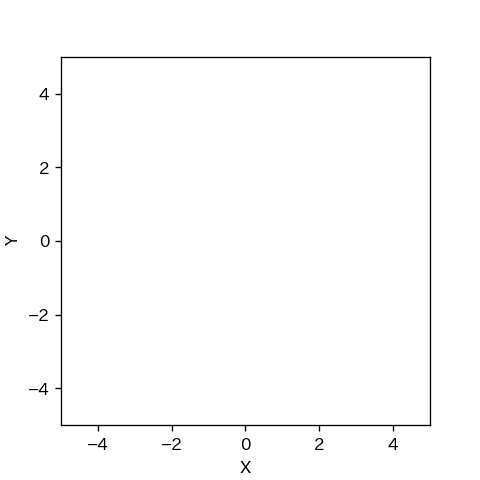

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs=np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id=observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p,self.map.landmarks[landmark_id].pos,*values)
            
        print(list([obs[0][0] for obs in observation]))
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

In [3]:
def trial_kidnap(animation): ###mclkidnap1test
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
    
    world.draw()
    
    return(r.pose, pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


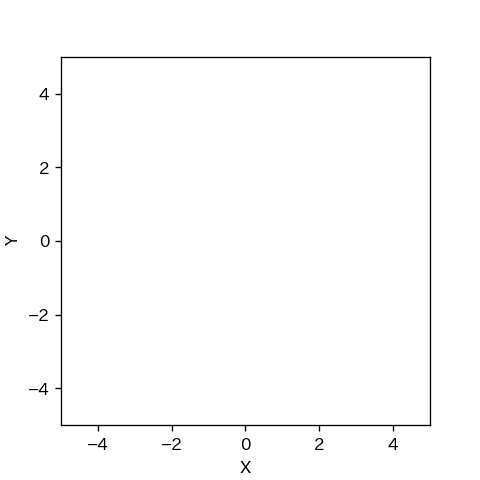

(array([-4.28854157,  2.39004393,  3.09270738]),
 array([-1.7613338 , -1.15533634, -2.13120512]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[2.3332202171892]
[5.000908474196928]
0 真値: [ 6.14271284 -1.05686724  2.00196331] 推定値: [-1.46101025 -0.1877561   0.39213895] 誤差: 7.653231938864178
1 真値: [ 2.74681015 -2.17793329  2.45717359] 推定値: [-0.09301921 -0.89351468  1.80667866] 誤差: 3.116787120800458
[0.4242615561198029]
2 真値: [-5.21789132  2.99256702  5.12200842] 推定値: [-4.99675467  2.8723369   5.11432141] 誤差: 0.25170756492227314
1
[4.914811269826292]
3 真値: [1.3670419  0.22885254 6.85811361] 推定値: [1.19972827 0.67340325 0.40966585] 誤差: 0.474993878543326
2
[3.398622281481373]
4 真値: [-0.26385013 -2.98182071  3.27560724] 推定値: [ 4.4132667  -2.64219855  0.30758425] 誤差: 4.689431207947041
[5.949352720874596]
5 真値: [-2.01755411  3.10048838  7.29286232] 推定値: [ 0.97777662 -2.11395841  2.11102865] 誤差: 6.0135232177029225
[0.5586558725188311]
6 真値: [1.48061633 4.16103765 4.45184988] 推定値: [1.53542266 3.79017504 4.34329081] 誤差: 0.37489039544655695
3
[5.246405256366907]
7 真値: [ 0.60723168 -2.69683356  4.48877227] 推定値: [ 3.85163745 -3.16684533  5.1

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[4.832881352727386]
20 真値: [ 0.12431613 -5.26511851  7.01873647] 推定値: [ 2.23695063 -6.06005033  1.47528827] 誤差: 2.257241931507629
[7.146372333380841]
21 真値: [-2.59821039 -0.04329793  7.88529133] 推定値: [-3.01330038 -1.37004326  1.21870315] 誤差: 1.3901628925542102
[4.186856107072948, 5.038279734251517]
22 真値: [-4.31599284 -3.40153134  6.18474782] 推定値: [-4.44561349 -2.8108604   6.08717337] 誤差: 0.6047261114981387
13
[2.545851306809125]
23 真値: [ 2.12555751 -1.80783819  3.97938287] 推定値: [ 2.13476118 -4.20207025  0.94333814] 誤差: 2.3942497442693425
[5.172861000883835]
[5.538348977663256]
24 真値: [ 1.9043419  -3.77273037  6.44714717] 推定値: [ 1.34659809 -3.97210837  7.12037071] 誤差: 0.5923088239173238
14
[5.034701142809663]
[3.1713279088581454]
25 真値: [-3.36763466  2.49722544  5.17380794] 推定値: [-2.99116304  1.91690761  4.05027053] 誤差: 0.6917367041518412
15
[0.7946053528082052]
26 真値: [-3.47915031  4.12747687  3.82492687] 推定値: [-3.61514327  3.93389258  3.80775163] 誤差: 0.23657760593752705
16
[1.0818736